In [1]:
import pandas as pd

In [ ]:
#Others (1895 - 1923)
dfo = pd.read_csv('catalog_v0.xlsx - other.csv')
dfo['Classe'] = 0
dfo.head()

In [ ]:
# Publishers Weekly’s Bestselling Novels,,,
dfs = pd.read_csv('catalog_v0.xlsx - success.csv')
dfs['Classe'] = 1
dfs.head()

In [ ]:
name = ''.join(dfs["Title"][0].split())
index = dfs["Index"][0]
namesearch = index + '_' + name
print(namesearch)

In [ ]:
concat = pd.concat([dfs, dfo], axis=0)
concat

## Reconhecimento de entidades

In [3]:
import os
import io
import re

from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from collections import Counter
import pandas as pd

In [4]:
import neuralcoref
import spacy 

In [5]:
print('spacy version:', spacy.__version__)
print('neuralcoref version:', neuralcoref.__version__)

spacy version: 2.1.3
neuralcoref version: 4.0.0


In [6]:
def read_file(path):
    try:
        with io.open(path, 'r', encoding='utf-8') as f:
            return f.read()
    except UnicodeDecodeError:
        try:
            with io.open(path, 'r', encoding='latin-1') as f:
                return f.read()
        except UnicodeDecodeError:
            return "Could not decode"
    

In [7]:
folder = "success"

# files sorted by number
files_ordered = sorted(os.listdir(folder), key=lambda name:int(name.split('_')[0]))

# an example file (1)
file = files_ordered[1]

# identifica os livros do dataset succes_others com os files
# if namesearch.lower() in file.lower():
#     print(namesearch, file)
#-----------------------------------------------------------

# name file
path = os.path.join(folder, file)

if os.path.isfile(path):
    content = read_file(path)
    print(f"Content of book ... {file}\n")
    # print(content)

Content of book ... 2_Trilby_GeorgeDuMaurier_cleared.txt



In [8]:
paragraphs = content.split('\n\n')
# print(paragraphs)

In [9]:
paragraphs_new = []
contents = []
chapters = []
old_idx = 0

for paragraph in paragraphs:
    # print("\n Paragraph: ", paragraph)
    
    lines = paragraph.split('\n')
    # print(lines)
    if re.match('[IVXLCDM\d]+[\.]*', lines[0].upper().strip()):
        if len(contents) == 0:
            contents = [" ".join(line.lower().split()) for line in lines]
            # print("contents", contents)
            
            if len(contents) == 0:
                print("Not found content", id_file)
                exit()
        continue
           
    if paragraph.lower().strip() in contents:
        if old_idx == 0:
            old_idx = len(paragraphs_new)
        else:
            current_idx = len(paragraphs_new)
            chapter = "\n\n".join(paragraphs_new[old_idx:current_idx])
            chapters.append(chapter)
            old_idx = current_idx
        continue
    
    if not re.match('.*[\w]+.*', paragraph):
        continue
    
    paragraphs_new.append(paragraph)
 

    if old_idx != 0:
        chapter = "\n\n".join(paragraphs_new[old_idx:len(paragraphs_new)])
        chapters.append(chapter)
        
print(len(paragraphs), len(paragraphs_new),
      #len(chapters)
     )    

2407 1987


In [10]:
nlp = spacy.load('en_core_web_sm')
neuralcoref.add_to_pipe(nlp)

In [11]:
data = []
geral_entities = []

for i, paragraph in enumerate(paragraphs_new[0:15]):
    paragraph = paragraph.replace('\n', ' ')
    paragraph = " ".join(paragraph.split())
    # print('\n', paragraph)****
    
    doc = nlp(paragraph)
    doc_coref = doc._.coref_resolved
    doc_coref = nlp(doc_coref)
    
    entities = []
    for ent in doc_coref.ents:
        if ent.label_ == "PERSON":
            entities.append(ent.text)
    
    if len(entities) > 0:
        len_words = len(paragraph.split())
        geral_entities.extend(entities)
        
        data.append((i, len_words, entities))
        # print('\n', paragraph)
        print(i, len_words, entities)

personagens = list(set(geral_entities) )

print("\nGeral Entities:\n", personagens)
# print("\nData:\n", data)

1 20 ['Mimi Pinson', 'Landérirette']
2 72 ['Broadwood']
3 74 ['Dante', "Michael Angelo's", 'Leda']
4 39 ['Rembrandt', 'Tintoret', 'Leonardo da Vinci', 'Botticelli', 'Mantegna']
5 129 ['Barye']
9 86 ['the Man of Blood', 'the Man of Blood', 'Bare-armed', 'the Man of Blood', 'the Man of Blood', 'the Man of Blood', 'the Man of Blood', 'the Man of Blood']
11 104 ['Sothern']
13 101 ['Sandy']

Geral Entities:
 ['the Man of Blood', 'Mimi Pinson', 'Sandy', "Michael Angelo's", 'Landérirette', 'Broadwood', 'Botticelli', 'Leda', 'Barye', 'Bare-armed', 'Tintoret', 'Rembrandt', 'Leonardo da Vinci', 'Mantegna', 'Dante', 'Sothern']


In [ ]:
print(geral_entities)
print('\n', Counter(geral_entities))

## Criação de rede de coocorrência

In [33]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Inicializa a matriz de coocorrência
cooccurrence_matrix = np.zeros((len(personagens), len(personagens)), dtype=int)

# Preenche a matriz de coocorrência
for _, _, paragraph_entities in data:
    for i in range(len(personagens)):
        if personagens[i] in paragraph_entities:
            for j in range(i, len(personagens)):
                if personagens[j] in paragraph_entities:
                    cooccurrence_matrix[i][j] += 1
                    if i != j:
                        cooccurrence_matrix[j][i] += 1
                               
print("Matriz de Coocorrência:")
print(cooccurrence_matrix)

Matriz de Coocorrência:
[[1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0]
 [0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0]
 [0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0]
 [0 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0]
 [0 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0]
 [0 0 0 0 0 0 1 0 0 0 1 1 1 1 0 0]
 [0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]]


In [34]:
co_matrix = np.array(cooccurrence_matrix)

# Lista de arestas a ser preenchida
edges = []

# Percorre a matriz de coocorrência
for i in range(len(personagens)):
    for j in range(i + 1, len(personagens)):
        # Se houver coocorrência, adiciona a aresta
        if co_matrix[i][j] > 0:
            edges.append((personagens[i], personagens[j]))

# Imprime a lista de arestas
print("Lista de Arestas (edges):")
print(edges)

Lista de Arestas (edges):
[('the Man of Blood', 'Bare-armed'), ('Mimi Pinson', 'Landérirette'), ("Michael Angelo's", 'Leda'), ("Michael Angelo's", 'Dante'), ('Botticelli', 'Tintoret'), ('Botticelli', 'Rembrandt'), ('Botticelli', 'Leonardo da Vinci'), ('Botticelli', 'Mantegna'), ('Leda', 'Dante'), ('Tintoret', 'Rembrandt'), ('Tintoret', 'Leonardo da Vinci'), ('Tintoret', 'Mantegna'), ('Rembrandt', 'Leonardo da Vinci'), ('Rembrandt', 'Mantegna'), ('Leonardo da Vinci', 'Mantegna')]


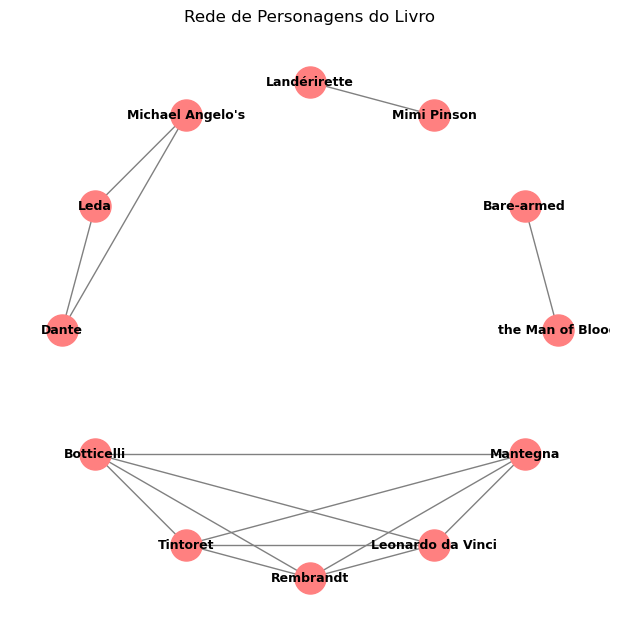

In [59]:
# Criação do grafo
G = nx.Graph()
G.add_edges_from(edges)

# Visualização do grafo
# pos = nx.spring_layout(G)
pos = nx.circular_layout(G)

plt.figure(figsize=(6, 6))

nx.draw(G,
        pos,
        with_labels=True,
        node_color="#FF8080",
        node_size=500,#**
        edge_cmap=plt.cm.GnBu,
        font_size=9,
        font_weight='bold',
        edge_color='gray',
        width=1)
plt.title("Rede de Personagens do Livro")
plt.show()

In [61]:
edges = G.edges()
weights = [G[u][v]['weight'] for u, v in edges]
colors = [G[u][v]['color'] for u, v in edges]

KeyError: 'weight'

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

matrix = cooccurrence_matrix
name_list = personagens
name_frequency = list(Counter(geral_entities).values()) #******

label = {i: i for i in name_list}
edge_list = edge_list # de celda anterior
# normalized_frequency = np.array(name_frequency) / np.max(name_frequency)

plt.figure(figsize=(20, 20))
G = nx.Graph()
G.add_nodes_from(name_list)
G.add_edges_from(edge_list)
pos = nx.circular_layout(G)
edges = G.edges()
weights = [G[u][v]['weight'] for u, v in edges]
colors = [G[u][v]['color'] for u, v in edges]

nx.draw(G,
        pos,
        node_color='#FF8080',
        node_size=np.sqrt(normalized_frequency) * 5000,
        edge_cmap=plt.cm.GnBu,
        linewidths=10, font_size=35, labels=label,
        edge_color=colors, 
        with_labels=True, 
        width=weights)

plt.show()